In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Sources and Citations

Fisman, R. J., Iyengar, S. S, Kamenica, E. & Simonson, I. (2006). *Gender Differences in Mate Selection: Evidence from a Speed Dating Experiment*. [http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating]. The Quarterly Journal of Economics. https://academiccommons.columbia.edu/doi/10.7916/D8FB585Z

Short post and supplemental information about the dataset and the associated experiment: [https://statmodeling.stat.columbia.edu/2008/01/21/the_speeddating_1](https://statmodeling.stat.columbia.edu/2008/01/21/the_speeddating_1). 

The link for the file share in the formal citation at the start of this cell has both the data in CSV format and a key for understanding the CSV: [http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating](http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating)

Dataset that I originally found and that led me to the source at the Columbia site: [https://www.openml.org/search?type=data&sort=runs&status=active&id=40536](https://www.openml.org/search?type=data&sort=runs&status=active&id=40536)

## Data and Research Paper Summary 

This dataset comes from an experiment by Raymond Fisman and Sheena Iyengar of the Columbia Business School about participants in a speed dating experiment. I found an open copy of the data hosted on a Columbia University file share from a well-known statistics professor at Columbia.

The researchers conducted a series of separate speed date events where they rotated participants through four-minute speed dates and asked participants to rate their partners after each date. The ratings are based around five attributes:

- Attractive
- Sincere
- Intelligent
- Fun
- Ambitious
- Shared interests

The researchers end up using attractiveness, intelligence, and ambition while dropping the remaining three attributes. Participants are also asked to fill out pre-event surveys to provide non-event data that is also used to determine degrees of similarity between participants. 

Part of the large feature space in the CSV is due to the combinations of attribute ratings across different partners, averages about individuals based on ratings by all of their partners, and other ways of combining the event survey and pre-event survey results.

The researchers focus on differential gender preferences about these attributes, trying to glean ways in which women and men value different characteristics during these dates. 

It is important to note a couple of potential issues with the experiment design. The participants were students in Columbia University graduate and professional programs, and the dates are heteronormative. These both restrict the generalizability of the findings. I am also curious about the justification of using speed dating as a stand-in for all dating since speed dating seems to me to be a very different experience from dating over a longer time scale.

The data explores how different demographics and personal characteristics affect participants' feelings about the speed dates they participate in. One target variable is the `match` column that indicates if both participants in the speed date want to meet again, but the experimental design allows for decisions that are more granular than match or no match, and the associated paper focuses on the `dec` column that has yes and no decisions by individuals about each date instead of matches that have yes decisions on both sides. The researchers use the `dec` values to determine what women and men value in partners, honing in on differences in what women and men prioritize.

The paper also references different social theories and starts to explore larger meanings about men and women based on this research's findings, including starting to challenge some of their own findings.

## Project

The choice of marriage partner is a perennial question. The more successful relationships out there, the better. On a personal note, I am looking at starting dating again myself, so I am curious about research that can help me to understand my own preferences and how those may fit in with dates that I go on. 

Because of the size of the feature space, layers of complexity, social theory, and prior knowledge built into the approach in the paper, I am going to attempt something simpler: can I predict if I will want a second date with someone and/or evaluate what factors are more important in terms of determining if I want a second date?

This is a classification problem that will use different features to predict if I will make a yes or no decision to see a person again at the end of the date. After training the model, I will provide most of the inputs before going on a date. Only one set of features will come from my experience on the date. This reduces the complexity of the model by quite a lot, but it keeps me from having to gather information from others in order to use the model, a simplification that I want to lean into for the first iteration, though this admittedly cuts out important information from the other person on the date that would help refine the model further and be more honest in terms of capturing both people's opinions about the date and about each other.

A next step of this analysis would be to begin to look at features leading to matches -- situations where both date participants say yes to a second date -- but I would rather break the progression to that up into steps.

## Fixing Bad Characters in Source CSV

The source CSV from the link above has some characters that got encoded with the Unicode replacement character, the diamond with a question mark in it. You can search for this by using a regex and looking for code `\uFFFD` or `\xEF\xBF\xBD`. These replacement characters look like the only non-ASCII characters. You can search for non-ASCII characters with the character set `[^\x00-\x7F]`. A visual scan of the bad rows looks like the characters are meant to be 'é'.

Sample bad value in the `undergra` field from the source CSV: Ecole Normale Sup�rieure, Paris


The following code block calls out to the shell to create a copy of the speed dating CSV and then run `sed` to replace the replacement characters with regular 'e's to keep everything in ASCII. I decided to use shell commands because I had trouble finding a way to read the bad characters in with Python, so I could not get to the step of replacing them in Python. I was able to manually change them with find and replace in Vim, so I modified that for `sed` for the solution below.

I ran this on MacOS. You may need to make some tweaks for Windows in particular.

In [2]:
! cp ./data/Speed\ Dating\ Data.csv ./data/speed_dating_data_fixed.csv
! sed -i '' 's/\xEF\xBF\xBD/e/g' ./data/speed_dating_data_fixed.csv  

## Loading and Initial Exploration

In [3]:
# The low_memory=False param tells pandas to determine column data types by looking at all rows
# in each column, resulting in needing to read in the entire CSV before being able to determine
# data types. low_memory=True results in chunking when reading in the file, and each chunk can
# infer a different data type.

df_raw = pd.read_csv('./data/speed_dating_data_fixed.csv', low_memory=False)
df_raw.head(10).iloc[:, 0:5] # Putting the first five columns since there are too many to be useful here

,iid,id,gender,idg,condtn
0,1.0,1.0,0.0,1,1
1,1.0,1.0,0.0,1,1
2,1.0,1.0,0.0,1,1
3,1.0,1.0,0.0,1,1
4,1.0,1.0,0.0,1,1
5,1.0,1.0,0.0,1,1
6,1.0,1.0,0.0,1,1
7,1.0,1.0,0.0,1,1
8,1.0,1.0,0.0,1,1
9,1.0,1.0,0.0,1,1


In [4]:
print(f'The dataset has {df_raw.shape[0]:,} rows and {df_raw.shape[1]} columns')

The dataset has 8,379 rows and 195 columns


## Column Summary

One of the more difficult aspects of this project is understanding and deciding what to do with the feature space of 195 columns. There are features with answers to the same questions asked at different times. There are features with speculative responses by participants. There are features with self-reported answers about questions such as what attributes someone likes in a partner, what someone thinks others find important in partners, and what others think about themselves. There are different approaches to ratings between different groups of participants. These and other particulars make the preprocessing for this dataset a bit trickier than expected. That said, because of the range of data available, the dataset does offer itself up to a range of questions.

One clarifying point for terminology. I use "participant" to refer to the individual that a row is for, "partner" for the other person participating in the date with the participant in that row, and "participants" (plural) to refer to more than one row or rows in general.

The details for these columns come from the "Speed Dating Data Key.doc" data dictionary reference document. 

Here is a general summary of the features:

There is a group of 28 questions that show up 4 times. Combined, these account for about 57% of the total columns. There is an interesting research question looking at what participants change during each of these repetitions, but I will go a different route and will not need to use all of these repetitions for my analysis.

These 28 repeating questions are related to these six attributes:

- Attractive
- Sincere
- Intelligent
- Fun
- Ambitious
- Shared interests (sometimes shared interests is not included)

This block of questions for each row asks that participant how they value these attributes, how they think fellow men or women value these attributes, how they think the opposite sex rates the importance of each of these attributes in potential partners, how participants rate themselves on these attributes, and how participants think others rate them on each of these attributes.

Note how within this repeating block of questions there are features that come from ratings that participants give themselves, that they predict about others, that they give to date partners, and that they receive from date partners. There is another interesting research question here about how participants may change their answers between repetitions, and there is another question looking at how self-ratings line up with ratings from date partners. I will not go into either of those directions with my analysis, but they would be interesting to look at.

Outside of the repeating block of features, there are a couple of other feature groupings that can help in understanding the feature space.

Intro info for a particular speed date:
- Different types of identifiers with different groupings
- Metadata about the event and date at event
- Boolean flag for match or no match
- Correlation between both participants' ratings of interest
- Boolean flag for same race
- Info about or from partner for that date, including preferences, decision about meeting again, and ratings of individual for that row

Signup/Time1 -- survey filled out by students interested in participating in speed dating event:
- Demographic and other personal info about survey applicant
- Ratings interest in different activities
- Expectations for the dating event
- First time answering the repeating block of questions

Scorecard -- filled out by participants after each date:
- Rate date partner on the six attributes
- Decision about wanting to meet that partner again
- Overall rating on partner and if you think they will say yes to wanting to see you again

Halfway point of speed dating event:
- Answer the repeating block of questions again

Followup/Time2 -- filled out the day after participating in an event:
- Feedback on the event
- Answer the repeating block of questions again

Followup2/Time3 -- 3-4 weeks after being sent matches:
- Feedback related to participants' matches
- Answer the repeating block of questions again

## What to Do With All These Features

Next is to narrow the feature space down to what we will use for modeling. We are keeping features that the participant controls without needing information from their date partner, with the one exception of the partner's age. The final group of ratings the participant makes about the partner happen after the date, but they still only require input from the participant. This simplifies the inputs since you do not need to survey the partner for the model. One obvious area to grow the model into is including more information from the partner as well.

The only categorical variable is `goal`. I am treating the 1-10 ratings in other columns as discrete numeric variables instead of as ordinal categorical variables since the current numeric encoding captures the order that we want for them.

Here are the features that we will keep:
- gender (boolean): indicates if participant is male or female
- age_o (continuous & in range [18,55]): partner's age
- age (continuous & in range [18,55]): participant's age
- goal (categorical): participant's primary goal in participating in event
    1. Seemed like a fun night out
    2. To meet new people
    3. To get a date
    4. Looking for a serious relationship
    5. To say I did it
    6. Other
- exphappy (discrete & in range [1,10]): how happy participant expects to be with people they meet at event

From here onwards, we encounter repetitions of the six attributes above. I will provide headers that explain what the repetitions are asking about instead of adding that as a description for each feature.

Here are the abbreviations:

- attr#_#: attractive
- sinc#_#: sincere
- intel#_#: intelligent
- fun#_#: fun
- amb#_#: ambitious
- shar#_#: shared interests

The data dictionary says that waves 6-9 rate some groups of these features on a 1-10 scale while the remaining waves distribute 100 points across all five or six features. Some feature groupings that the dictionary indicates should be [1,10] are already rescaled to [0,100] such that the total of all of the features in the grouping for each row sum to 100, so the standardization turned [1,10] ratings into relative ratings on a [1,100] percentage scale. 

For groupings that require further standardization, we will do the same by summing the total for the grouping for a row and standardize it if the amount does not sum to 100. One catch is that this will treat any group of ratings that are the same number across all of the measures as the same. For instance, a grouping of (1,1,1,1,1,1) and (9,9,9,9,9,9) both result in each of their values ending up as 16.67, so we lose the fact that one group was 1s and the other 9s while retaining the relative ranking between features within each grouping. For this analysis, that will work, but this is an area to circle back to for future analyses.

This means that the data type for each of these columns will end up being continuous & in range [0,100].

Now, back to the columns.

These six features are related to what the participant looks for in the opposite sex:
- attr1_1
- sinc1_1
- intel1_1
- fun1_1
- amb1_1
- shar1_1

The next six features are what the participant thinks most of their fellow men/women look for in the opposite sex:
- attr4_1
- sinc4_1
- intel4_1
- fun4_1
- amb4_1
- shar4_1

The next six features are what the participant thinks the opposite sex looks for in a date:
- attr2_1
- sinc2_1
- intel2_1
- fun2_1
- amb2_1
- shar2_1

The next five features are how the participant rates themselves (discrete & in range [1,10]):
- attr3_1
- sinc3_1
- intel3_1
- fun3_1
- amb3_1

The next five features are how the participant thinks others would rate them (discrete & in range [1,10]):
- attr5_1
- sinc5_1
- intel5_1
- fun5_1
- amb5_1

Moving on to information collected at the dates:
- dec (boolean): does the participant want to meet their date partner again

Next is how the participant rates their date on the six attributes from above (discrete & in range [1,10]): 
- attr
- sinc
- intel
- fun
- amb
- shar

And two final features related to the specific date:
- like (discrete & in range [1,10]): how much the participant likes their date overall
- prob (discrete & in range [1,10]): how probable do you think it is that your partner will want to see you again

## Preprocessing & Exploratory Data Analysis

As usual, much of the time on a data project is spent on preprocessing and cleaning, and that applies here too. We will do a couple rounds of clean-up with different types of numerical and visual checks along the way as we refine down the final dataset that we will use for modeling.

In [5]:
# Adding .copy() so we do not get a SettingWithCopyError in the next cell
# due to trying to modify the subset df of the original df_raw dataframe
df = df_raw.copy()[[
     'dec' # moving target to the front of the columns
    , 'gender'
    , 'age_o'
    , 'age'
    , 'goal'
    , 'exphappy'
    , 'attr1_1'
    , 'sinc1_1'
    , 'intel1_1'
    , 'fun1_1'
    , 'amb1_1'
    , 'shar1_1'
    , 'attr4_1'
    , 'sinc4_1'
    , 'intel4_1'
    , 'fun4_1'
    , 'amb4_1'
    , 'shar4_1'
    , 'attr2_1'
    , 'sinc2_1'
    , 'intel2_1'
    , 'fun2_1'
    , 'amb2_1'
    , 'shar2_1'
    , 'attr3_1'
    , 'sinc3_1'
    , 'intel3_1'
    , 'fun3_1'
    , 'amb3_1'
    , 'attr5_1'
    , 'sinc5_1'
    , 'intel5_1'
    , 'fun5_1'
    , 'amb5_1'
    , 'attr'
    , 'sinc'
    , 'intel'
    , 'fun'
    , 'amb'
    , 'shar'
    , 'like'
    , 'prob'
]]

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n')
df.dtypes.unique()

The dataset has 8,379 rows and 42 columns



array([dtype('float64')], dtype=object)

We see that all of the remaining columns were read in as numbers.

Based on the column analysis above, we know that `goal` is categorical, so we will encode that with one-hot encoding. Some of the models will not need the encoding, and the encoding can end up contributing to overfitting in models such as decision trees, but it is more straightforward at this stage to compare the models with the same dataset, and we are only one-hot encoding for six levels, so I am not too worried about some of the more common downsides.

The remaining columns can stay as floats.

Next we will clean up values that are outside of expected ranges or invalid. We are going to do this one column at a time. There is likely a cleaner way to do this, but there is not as much to check here as it seems since many of the columns share the same [1,10] or [1,100] range. 

In [6]:
# You can run this block before and after doing clean-up in the next code block.
for col in df:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')

dec: [0.0, 1.0, 5.0, nan]

gender: [0.0, 1.0, nan]

age_o: [2.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 42.0, 55.0, nan]

age: [18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 42.0, 55.0, 70.0, nan]

goal: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 50.0, nan]

exphappy: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

attr1_1: [0.0, 2.0, 5.0, 6.67, 7.0, 7.5, 8.0, 8.33, 8.51, 9.0, 9.09, 9.52, 9.76, 10.0, 11.11, 11.36, 11.54, 12.0, 12.24, 12.77, 13.04, 13.21, 13.51, 14.0, 14.29, 14.55, 14.58, 14.71, 14.89, 15.0, 15.09, 15.22, 15.38, 15.52, 15.56, 15.91, 16.0, 16.07, 16.28, 16.36, 16.67, 16.98, 17.0, 17.02, 17.24, 17.31, 17.39, 17.5, 17.65, 17.78, 18.0, 18.18, 18.37, 18.6, 18.75, 19.0, 19.05, 19.15, 19.44, 19.57, 19.61, 20.0, 20.45, 20.51, 20.83, 20.93, 21.0, 21.28, 21.43, 22.0, 23.0, 23.81, 24.0, 25.0, 25.64, 27.0, 2

In [7]:
df.loc[df['dec'] == 5, 'dec'] = 1.0
df.loc[df['age_o'] == 2.0, 'age_o'] = np.nan
df.loc[df['age'] == 70.0, 'age'] = np.nan
df.loc[df['goal'] == 50.0, 'goal'] = 5.0
df.loc[df['sinc3_1'] == 15.0, 'sinc3_1'] = np.nan
df.loc[df['attr5_1'] == 70.0, 'attr5_1'] = 7.0
df.loc[df['intel5_1'] == 15.0, 'intel5_1'] = np.nan
df.loc[df['attr'] == 80.0, 'attr'] = 8.0
df.loc[df['like'] == 50.0, 'like'] = 5.0

In [8]:
df.corr().loc['dec'].sort_values(ascending=False)

dec         1.000000
like        0.513264
attr        0.486770
fun         0.414253
shar        0.400707
prob        0.310825
intel       0.216972
sinc        0.209170
amb         0.182992
gender      0.110345
exphappy    0.094800
sinc2_1     0.073329
intel2_1    0.070898
shar1_1     0.042533
intel3_1    0.039531
intel5_1    0.039144
amb2_1      0.032517
shar4_1     0.031276
fun4_1      0.030220
sinc1_1     0.028061
amb5_1      0.026149
shar2_1     0.019213
intel4_1    0.015938
age         0.015846
amb3_1      0.007255
goal       -0.001633
sinc4_1    -0.002040
fun1_1     -0.003198
intel1_1   -0.007036
fun3_1     -0.008857
sinc5_1    -0.012319
sinc3_1    -0.018496
fun2_1     -0.020820
attr1_1    -0.020968
amb1_1     -0.022054
attr4_1    -0.032497
fun5_1     -0.032674
amb4_1     -0.042034
attr3_1    -0.047457
age_o      -0.049520
attr2_1    -0.068150
attr5_1    -0.070551
Name: dec, dtype: float64

The correlation for most of these columns is relatively small. We may be able to trim the feature space further because of this in order to simplify the models.

First we will clean up missing values. We will also snag a few datasets with different approaches for handling missing values to test out later.

In [9]:
df.isna().sum().sort_values(ascending=False)

intel5_1    3474
amb5_1      3473
attr5_1     3473
fun5_1      3473
sinc5_1     3473
shar4_1     1913
intel4_1    1891
amb4_1      1891
fun4_1      1891
attr4_1     1891
sinc4_1     1891
shar        1068
amb          713
fun          351
prob         310
intel        297
sinc         278
like         241
attr         203
shar1_1      123
sinc3_1      107
intel3_1     106
fun3_1       106
amb3_1       106
attr3_1      106
age_o        105
exphappy     102
amb1_1       101
age           96
fun1_1        91
amb2_1        90
shar2_1       90
sinc2_1       81
attr2_1       81
fun2_1        80
intel2_1      80
intel1_1      80
sinc1_1       80
attr1_1       80
goal          80
gender         1
dec            1
dtype: int64

A little under half of the rows are missing values for the category of how you think others would rate you. The correlation across these features is pretty low. There is some speculation in these questions that would be interesting to explore for explanatory purposes, especially looking at how similar participants rate themselves compared how they think others would rate them. For instance, if those two sets of ratings are pretty different, we may try to figure out what that says about that participant and how those differences show up in terms of date outcomes or in other features.

Next, about a quarter of the rows are missing values for the group of questions related to what the participant thinks most of their fellow men/women look for in the opposite sex. The correlation for these features is also small. Similar to the previous group, there is speculation here in asking participants to guess what others think is important in a partner. Same thoughts about this being interesting for other purposes also hold here.

For similar logic, we will also drop the group of features related to what the participant thinks the opposite sex looks for in a date. Since we are dropping the two speculative groups above, it makes sense at this point to drop this group as well.

We will go ahead and drop these groups of features so that we do not end up losing or imputing all of those rows. To repeat, these groups are interesting if we were to look at inconsistencies between groups of features and try to delve into the psychology there, but we will save that for another project.

We can also drop the two rows that are missing values for `dec` or `gender` since there are only two.

In [10]:
df.drop(columns=[
    'attr5_1'
    , 'sinc5_1'
    , 'intel5_1'
    , 'fun5_1'
    , 'amb5_1'
    , 'attr4_1'
    , 'sinc4_1'
    , 'intel4_1'
    , 'fun4_1'
    , 'amb4_1'
    , 'shar4_1'
    , 'attr2_1'
    , 'sinc2_1'
    , 'intel2_1'
    , 'fun2_1'
    , 'amb2_1'
    , 'shar2_1'
    ], inplace=True
)

df.dropna(subset=['dec', 'gender'], inplace=True)

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns')

The dataset has 8,377 rows and 25 columns


Now that we have a further trimmed feature space, we can look at a full correlation matrix.

Note that there are blocks of higher correlation within groups of features for each of the attribute questions that we kept in the dataset, especially for the block for rating the date partner. This would make for another interesting question looking at how someone may rate all attributes higher when they find someone they like rather than rating only some of the attributes higher. But, again, that is for a follow-up project.

The correlation values between features are significant for this type of psychometric data, but they are not high enough for us to start removing groups of columns and replacing them with a proxy. We could look at principal components analysis (PCA), linear discriminant analysis (LDA), or regularization to reduce the feature space, but I do not think we are looking at enough columns that we need to purposely trim the feature space further, especially since the output for the modeling is predictive and not explanatory.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5]),
 [Text(0, 0.5, 'dec'),
  Text(0, 1.5, 'gender'),
  Text(0, 2.5, 'age_o'),
  Text(0, 3.5, 'age'),
  Text(0, 4.5, 'goal'),
  Text(0, 5.5, 'exphappy'),
  Text(0, 6.5, 'attr1_1'),
  Text(0, 7.5, 'sinc1_1'),
  Text(0, 8.5, 'intel1_1'),
  Text(0, 9.5, 'fun1_1'),
  Text(0, 10.5, 'amb1_1'),
  Text(0, 11.5, 'shar1_1'),
  Text(0, 12.5, 'attr3_1'),
  Text(0, 13.5, 'sinc3_1'),
  Text(0, 14.5, 'intel3_1'),
  Text(0, 15.5, 'fun3_1'),
  Text(0, 16.5, 'amb3_1'),
  Text(0, 17.5, 'attr'),
  Text(0, 18.5, 'sinc'),
  Text(0, 19.5, 'intel'),
  Text(0, 20.5, 'fun'),
  Text(0, 21.5, 'amb'),
  Text(0, 22.5, 'shar'),
  Text(0, 23.5, 'like'),
  Text(0, 24.5, 'prob')])

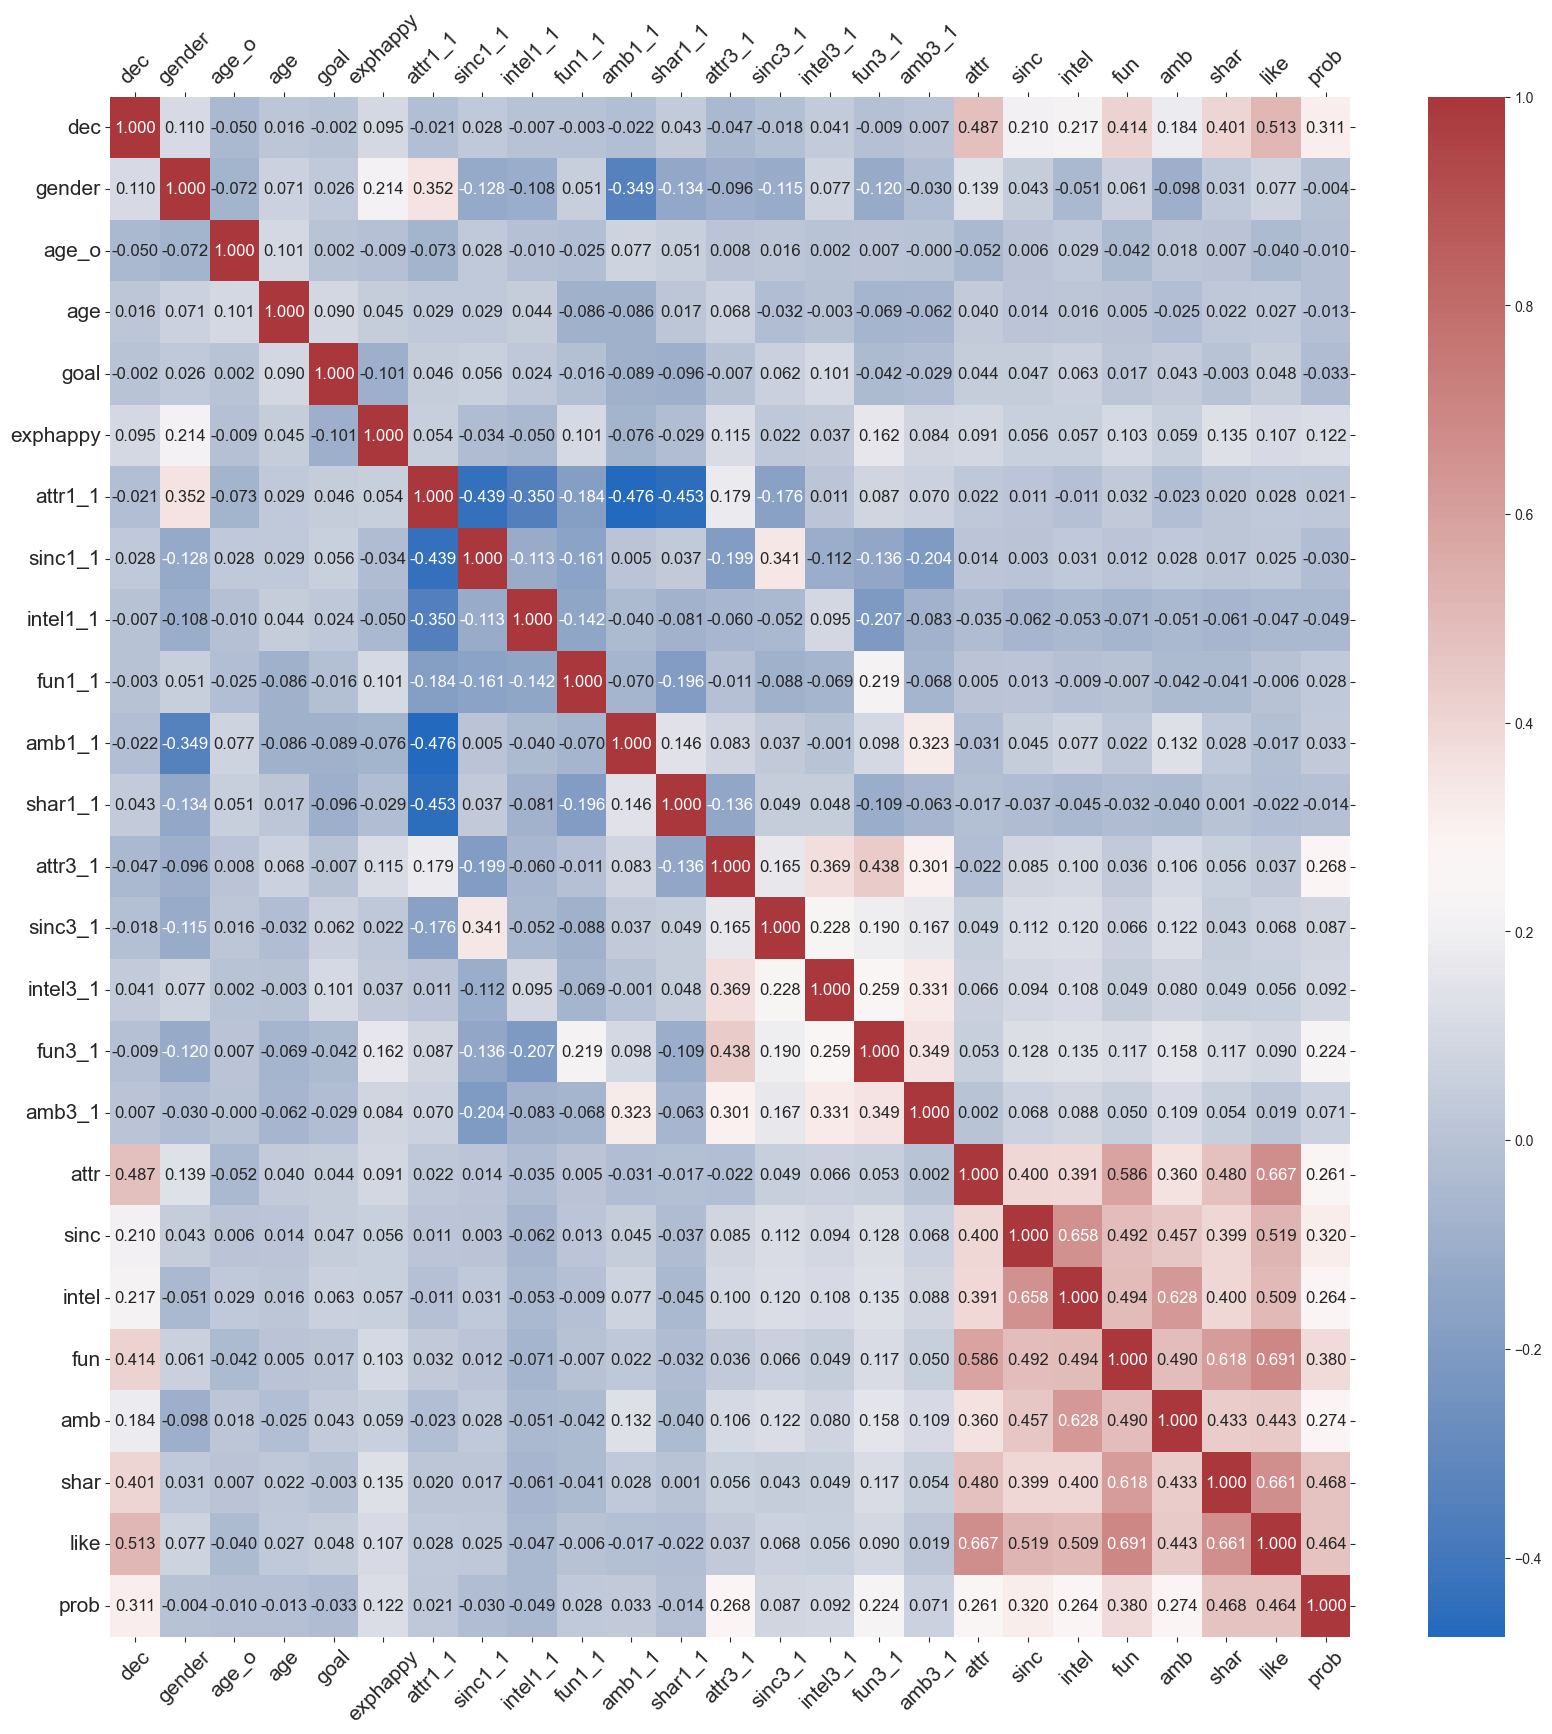

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(
    df.corr(),
    cmap='vlag',
    annot=True,
    annot_kws={'fontsize': 12},
    fmt='.3f'
)

plt.tick_params(
    left=True, top=True, right=True, bottom=True,
    labelleft=True, labeltop=True, labelright=False, labelbottom=True,
    labelsize=15
)

plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')

Next we can look at univariate distributions. We manually cleaned up outliers above, but these distributions can help us determine a strategy for handling missing data. We can rerun the cell above that shows counts of missing values and check the distributions to determine if we can impute the mean or median. We can also opt to drop rows with missing values or go the other direction and use a more sophisticated imputation method using regression.

Yes, the distribution lines look funny. I experimented with a few different displays. Barplots are the logical choice since each of the features has discrete data, either numeric or boolean, but `sns.barplot()` takes a prohibitively long time to run and ends looking similar enough to histograms and KDE plots to substitute those in for it. Histograms turn out to look okay-ish for everything other than boolean features, but the density plots capture the same information in a cleaner interface. We do get some dips down between discrete integer values, but we are looking at the general distribution shapes, and the density plots allow for that.

Overall, there does not appear to be anything that stands out as majorly wrong from these plots. There is one person aged 55, and that is an outlier for the general age range of participants. Some of the [1,100] columns have what appear to be outliers based on the plots, but the values look valid and important to keep as is based on the questions that participants answered and after reading through details in the published paper about how the researchers understood using the data.

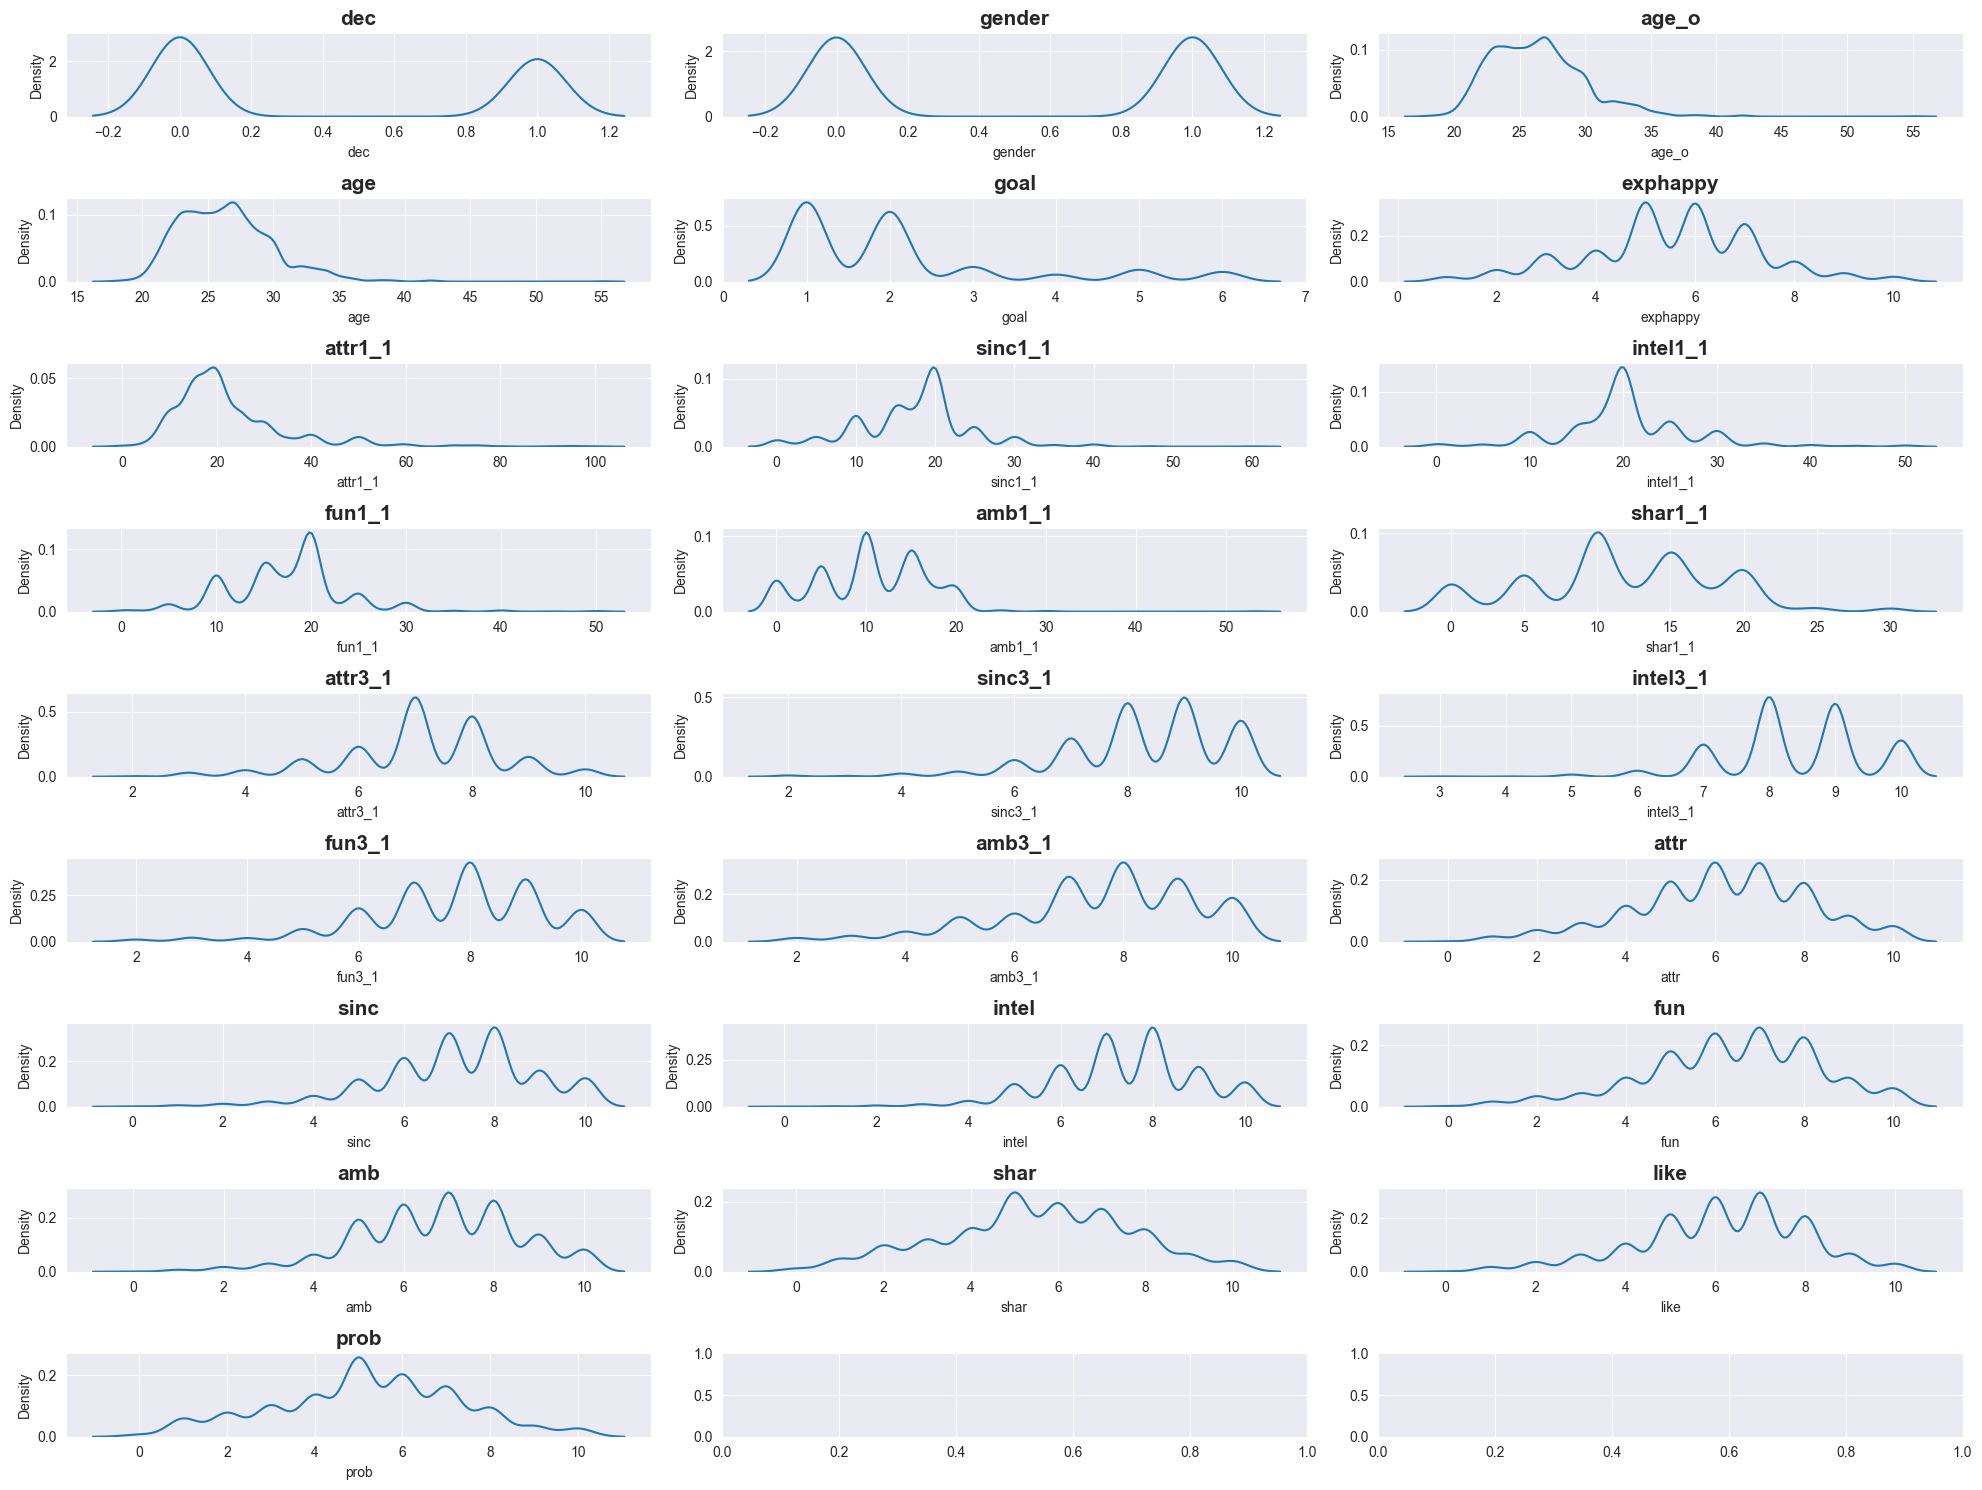

In [12]:
nrow=int(np.ceil(df.shape[1]/3))
ncol=3

fig, axes = plt.subplots(nrow, ncol, figsize=(20,15))

for i in range(nrow):
    for j in range(ncol):
        if 3*i+j >= df.shape[1]:
            break
        sns.kdeplot(df.iloc[:,3*i+j], ax=axes[i,j])
        axes[i,j].set_title(df.columns[3*i+j], fontsize=15, fontweight='bold')
fig.tight_layout()

Most of the distributions look skewed, so we will avoid the mean. 

In [13]:
print(f'The dataset has {df.dropna().shape[0]:,} rows when we drop any row with a missing value, '
      f'leaving us with {df.dropna().shape[0]/ df_raw.shape[0]:,.3} of the original dataset')

The dataset has 6,735 rows when we drop any row with a missing value, leaving us with 0.804 of the original dataset


The quickest answer is to drop all rows that have missing values, but this loses about 20% of the rows. Next would be to test imputation by median because of the skewness in many of the univariate feature distributions, but we need to look over the missing data to make sure the missing values are random. If they are not, then imputing the median may introduce bias into the models.

My approach is to pull the subset of rows with missing data in the next code block and check out those rows in the original dataset. I am looking for any patterns in `wave` in particular. The data dictionary does say that some questions are asked differently to different waves.

In [14]:
df[df.isnull().any(axis=1)]

,dec,gender,age_o,age,goal,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,...,fun3_1,amb3_1,attr,sinc,intel,fun,amb,shar,like,prob
2,1.0,0.0,22.0,21.0,2.0,3.0,15.0,20.0,20.0,15.0,...,8.0,7.0,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
24,0.0,0.0,24.0,25.0,6.0,4.0,35.0,10.0,35.0,10.0,...,8.0,8.0,9.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN
25,0.0,0.0,25.0,25.0,6.0,4.0,35.0,10.0,35.0,10.0,...,8.0,8.0,8.0,10.0,10.0,7.0,9.0,9.0,8.0,NaN
90,0.0,0.0,27.0,26.0,2.0,7.0,15.0,15.0,15.0,40.0,...,10.0,9.0,6.0,10.0,10.0,6.0,6.0,NaN,6.0,3.0
91,0.0,0.0,22.0,26.0,2.0,7.0,15.0,15.0,15.0,40.0,...,10.0,9.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,0.0,1.0,24.0,25.0,1.0,10.0,70.0,0.0,15.0,15.0,...,6.0,7.0,7.0,5.0,5.0,5.0,6.0,NaN,4.0,4.0
8373,0.0,1.0,26.0,25.0,1.0,10.0,70.0,0.0,15.0,15.0,...,6.0,7.0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0
8374,0.0,1.0,24.0,25.0,1.0,10.0,70.0,0.0,15.0,15.0,...,6.0,7.0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0
8375,0.0,1.0,29.0,25.0,1.0,10.0,70.0,0.0,15.0,15.0,...,6.0,7.0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0


Checking these rows against the original dataset, I do not see correlations with `wave`. I was looking at correlation with that feature in particular because the dictionary does indicate that there were some differences in instruction between different waves. 

Here are the steps for cleaning the remaining columsn with missing values. The order is important for this block of preprocessing.

1. We should drop rows that are missing values for `age`, `age_o`, and `goal`. Without running a more complicated model to impute these values based on context, it seems safer to drop them instead of impute the median, and there are not too many rows here.
2. The \*3_\* columns are missing values for all six attributes at a time, so we can go ahead and drop these instead of introducing values here with the median for each feature since I cannot quite tell if these are missing at random.
3. `fun1_1`, `amb1_1`, and `shar1_1` are missing because the participant for those rows used up their 100 distributed points across the other features, so these should be 0.0.
4. Next are the six features for rating the date partner. For many of these rows, there are values for a couple of the features. It looks like participants left blanks in place of 0s. We will fill rows where only some of these six features are missing values with 0s for the missing values.
5. There are only 168 rows where all six of the features for rating the date partner are null, so we will drop these now.
6. We can drop the 26 rows with missing values for `like`. This is the column with the highest correlation with `dec`.
7. We only have 50 rows remaining in `prob` that are missing. I do not see any context that can help with these. Fortunately, dropping these 50 rows still leaves us with about 94% of the original amount of rows, so we can stick with dropping them instead of looking at more complicated imputation. This dataset is complex enough to start with, so simplicity seems right here.

In [15]:
# 1 & 2
df.dropna(subset=[
    'age'
    , 'age_o'
    , 'goal'
    , 'attr3_1'
    , 'sinc3_1'
    , 'intel3_1'
    , 'fun3_1'
    , 'amb3_1'
    ], inplace=True
)

# 3
df.fillna({'fun1_1': 0.0, 'amb1_1': 0.0, 'shar1_1': 0.0}, inplace=True)

# 4
# Grabs rows where at least one of these features is missing and at least one has a value
filter_condition = (
    df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']].isna().any(axis=1) 
    & ~df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']].isna().all(axis=1)
)
df.loc[filter_condition] = df.loc[filter_condition].fillna(0.0)

# 5
df.dropna(subset=['attr', 'sinc', 'intel', 'fun', 'amb', 'shar'], inplace=True)

# 6 -- making this a separate line of code to match the process and steps above
df.dropna(subset=['like'], inplace=True)

# 7 -- making this a separate line of code to match the process and steps above
df.dropna(subset=['prob'], inplace=True)

print(f'The dataset has {df.shape[0]:,} rows after cleaning up missing values, and the original dataset '
      f'has {df_raw.shape[0]:,} rows, leaving us with {df.shape[0]/df_raw.shape[0]:,.3} of the original dataset')


The dataset has 7,896 rows after cleaning up missing values, and the original dataset has 8,379 rows, leaving us with 0.942 of the original dataset


I was not able to find an automated way to clean these that I was happy with, so I went with the more manual steps above. The result is that we only drop about 5% of the rows in the dataset during cleaning, and the manual imputations, primarily of 0s, feels better than something like median imputation.

The final preprocessing step is to make sure the ratings columns values look right. The block of features for rating the date participant have non-integer values, but we are treating these as ordinal numeric inputs already, so leaving in the non-integer values should be fine for the modeling below.

Earlier we mentioned that we would need to standardize columns that have mixes of input ranges for [1,10] and [1,100] as mentioned earlier. The *1_1 features are the only remaining features that need this clean-up, and the dataset already has this fix in place, so we just need to look for mistakes. 

There are 133 rows that have sums across the *1_1 features that are below 99.98 or above 101. We widen the range around 100 for minor differences. We can drop the remaining 133 rows since there are not many of them. I do not see any patterns in these rows that hint at an easy manual fix, and adding in the complexity of rescaling the values for just 133 columns is not worth the added complexity and avoids the confusion of rescaling only a small number of these when it is unclear from the start why the dictionary says we should see [1,10] values but the dataset looks like someone already when in and did some rescaling.

In [16]:
np.sort(df[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1).unique().tolist())

array([ 90.  ,  95.  ,  99.98,  99.99,  99.99,  99.99, 100.  , 100.  ,
       100.  , 100.01, 100.01, 100.02, 100.02, 101.  , 110.  , 120.  ,
       148.  ])

In [17]:
sum_filter = df[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df_sums = df[(sum_filter < 99.98) | (sum_filter > 101)]

print(f'There are {df_sums.shape[0]} rows that have sums less than 99.98 or greater than 101 for the *1_1 features')
df.drop(df_sums.index, inplace=True)

print(f'The final preprocessed dataset has {df.shape[0]:,} rows, and the original dataset has {df_raw.shape[0]:,} '
      f'rows, leaving us with {df.shape[0]/df_raw.shape[0]:,.3} of the original dataset')

There are 133 rows that have sums less than 99.98 or greater than 101 for the *1_1 features
The final preprocessed dataset has 7,763 rows, and the original dataset has 8,379 rows, leaving us with 0.926 of the original dataset


Before we finish up preprocessing, we need to do one more numeric and/or visual check to make sure the dataset is what we are expecting and that we understand the likely trends in the data. We also need to split and standardize the dataset.

After going through all of that preprocessing, we should still ask if we want or need all the features. We can choose a cut-off such as features having a correlation greater than 0.1. This would leave us with `gender`, `attr`, `sinc`, `intel`, `fun`, `amb`, `shar`, `like`, and `prob`. The six features for rating the date partner make sense for showing up here. Same for correlation with how much the participant liked their date partner and if they felt it probable that their partner would want to see them again too. Gender is interesting in that it is hinting that men are more likely to say yes than women, though this does fit with some of the findings of the published paper, and they explain some reasons behind this.

After that, `exphappy` seems useful to include. It makes sense to me that someone expecting their dates to turn out positively would be more inclined to want to see date partners again, and it has the next highest correlation.

We will keep `goal` since it is categorical and hasn't been encoded yet for modeling.

For the remaining ratings blocks, I am split on the best way forward. The correlations are pretty small. For explanatory purposes, I think it is important to keep all the features in each block, and we could choose to keep or remove blocks as a whole. For predictive purposes, we could be more flexible with that, but the remaining features we would consider keeping are small in correlation regardless.

Note that the correlation matrix above showed us that we are not in danger of multicollinearity with the features here, though we did check for that.

In [18]:
df.corr().loc['dec']

dec         1.000000
gender      0.105882
age_o      -0.051351
age         0.011625
goal       -0.007658
exphappy    0.089775
attr1_1    -0.037829
sinc1_1     0.038421
intel1_1   -0.005749
fun1_1     -0.000491
amb1_1     -0.023851
shar1_1     0.058529
attr3_1    -0.045514
sinc3_1    -0.016387
intel3_1    0.037188
fun3_1     -0.015487
amb3_1      0.003936
attr        0.479442
sinc        0.198964
intel       0.194359
fun         0.374953
amb         0.110447
shar        0.302990
like        0.508206
prob        0.315757
Name: dec, dtype: float64

We will one-hot encode `goal` and then split the dataset with an 80-20 train-test split, and then standardize the dataset. The dataset should then be ready to start testing out models below.

Not all machine learning algorithms will need standardized data, but we can go ahead and standardize everything since our goal is prediction.

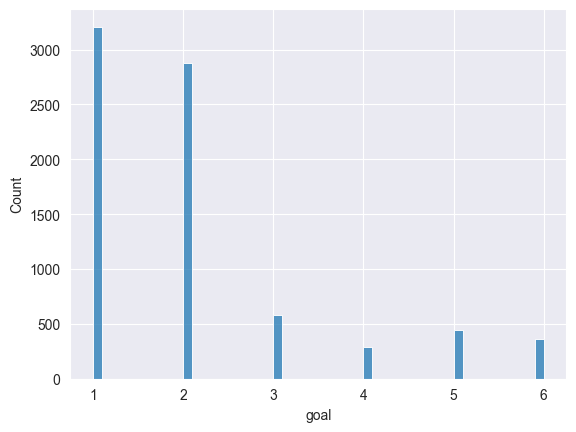

In [19]:
# encoder = OneHotEncoder(drop='first')
# goal_encoded = encoder.fit_transform(df['goal'].values.reshape(-1,1))
# 
# df_goal_encoded = pd.DataFrame(goal_encoded.toarray(), columns=encoder.get_feature_names_out(['goal']))
# df_goal_encoded
# 
# pd.concat([df.drop('goal', axis=1), df_goal_encoded], axis=1)

# Encode the goal feature
sns.histplot(df['goal'], stat='count')
df_goal_encoded = pd.get_dummies(df['goal'], dtype='float', drop_first=True)
df_encoded = pd.concat([df.drop('goal', axis=1), df_goal_encoded], axis=1)
df_encoded.columns = df_encoded.columns.astype(str)

# 80-20 train-test split
x_train, x_test, y_train, y_test = train_test_split(
    df_encoded.drop('dec', axis=1)
    , df_encoded['dec']
    , test_size=0.2
    , random_state=42
)

# There is an sklearn pipeline function to do this, but I find this situation simple enough to do by hand
x_train_num = x_train.drop(columns=['gender', '2.0', '3.0', '4.0', '5.0', '6.0'])
x_train_bool = x_train[['gender', '2.0', '3.0', '4.0', '5.0', '6.0']]
x_test_num = x_test.drop(columns=['gender', '2.0', '3.0', '4.0', '5.0', '6.0'])
x_test_bool = x_test[['gender', '2.0', '3.0', '4.0', '5.0', '6.0']]

# Standardize the dataset
scaler = StandardScaler()

x_train_num_scaled = pd.DataFrame(scaler.fit_transform(x_train_num), columns=x_train_num.columns)
x_test_num_scaled = pd.DataFrame(scaler.transform(x_test_num), columns=x_test_num.columns)

x_train_scaled = pd.concat([x_train_num_scaled, x_train_bool.reset_index(drop=True)], axis=1)
x_test_scaled = pd.concat([x_test_num_scaled, x_test_bool.reset_index(drop=True)], axis=1)

We are now all set for preprocessing. We have trimmed the feature space by a lot. There will be opportunities to trim it further when testing out models later, but I prefer to keep a wider dataset at this stage before jumping into model testing.

We handled invalid and missing values, only losing about 8% of the rows in doing so. We did this in stages, checking along the way the effects of dropping rows or columns, imputing values, or manually imputing values based on visual inspection, with the latter actually being pretty useful and manageable for this dataset.

We then used a mixture of numeric and visual checks to make further sense of the dataset and required preprocessing. We checked univariate distributions and based some preprocessing decisions based on those plots. We also checked correlations with `dec` and a full correlation matrix. There are a handful of features with stronger correlation with the target, and there are a chunk of remaining features with lower correlations that we may still want to trim. We also did not see signs of multicollinearity that we needed to adjust for, though we still might look at regularization or dimensionality reduction later, though my sense is that the preprocessing for this dataset is robust enough at this point since we do not see strong evidence that we need to start adding in more complicated preprocessing. Though they are options we can use if desired.

We finished up by one-hot encoding the `goal` categorical feature and dropping one of its encoded columns to avoid multicollinearity. We then created a train-test split, standardized the numeric columns, and packaged up our encoded and scaled train and test sets to use next in modeling.

## Model Identification

I also want to test out a few different classification models. The obvious model for a binary classification problem is logistic regression. I also want to test out support vector machines (SVM), especially for a larger feature space. Finally, I would like to test out a tree-based model, but the specifics for this one will depend on what I find from some of the feature reduction.


## Model Building

## Model Training

## Results

## Conclusion